In [1]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.special import kl_div, ndtr

# from exp import ecdf


def ecdf(exp):
    exp_ou = sorted(set(exp))
    freq = [collections.Counter(exp)[i] for i in exp_ou]
    # print(f"freq=")
    cdf = np.cumsum(freq) / sum(freq)
    # print(f"cdf=")
    return dict(zip(exp_ou, cdf))


def kde_cdf(kde, x):
    return np.array(
        [ndtr(np.ravel(item - kde.dataset) / kde.factor).mean() for item in x]
    )

# 实验数据
将实验记录数据以分段cdf函数形式呈现。

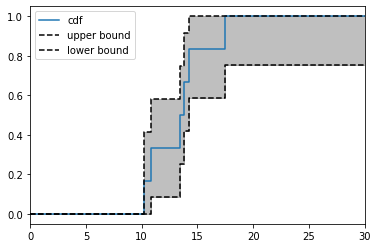

In [2]:
exp = [13.43, 17.47, 14.22, 10.80, 10.24833, 13.79]
exp_ou = sorted(set(exp))
y_ecdf = [ecdf(exp)[i] for i in exp_ou]

delta = 0.2483
# delta = 0.3
y_ecdf_u = [np.clip(ecdf(exp)[i] + delta, 0, 1) for i in exp_ou]
y_ecdf_l = [np.clip(ecdf(exp)[i] - delta, 0, 1) for i in exp_ou]

plt.step([0, *exp_ou, 40], [0, *y_ecdf, 1], where="post", label="cdf")
plt.step([0, *exp_ou, 40], [0, *y_ecdf_u, 1], "k--", where="post", label="upper bound")
plt.step([0, *exp_ou, 40], [0, *y_ecdf_l, 1], "k--", where="post", label="lower bound")
plt.fill_between(
    [0, *exp_ou, 40],
    [0, *y_ecdf_u, 1],
    [0, *y_ecdf_l, 1],
    step="post",
    alpha=0.5,
    color="grey",
)
plt.xlim([0, 30])
plt.legend()

# 理论模型
建立理论模型，并通过蒙特卡洛方法与高斯核函数拟合对模型进行不确定性量化。建立 f 类，其中包含模型，$model$，以及与之对应的$pdf$与$cdf$函数。模型建立过程中因为理论缺陷，引入修正系数c。模型结果会偏大，所以c小于1，此处选用

$$c=0.45。$$


In [3]:
class f:
    def __init__(self, params):
        mu = params[0]
        sigma = params[1]
        self.p = stats.norm(mu, sigma)
        self.t = stats.uniform(64, 66 - 64)
        self.r = stats.uniform(8.48, 8.52 - 8.48)

        samples = 20_000
        data = [
            self.p.rvs(samples, random_state=1),
            self.t.rvs(samples, random_state=1),
            self.r.rvs(samples, random_state=1),
        ]
        y = [self.model(data[0][i], data[1][i], data[2][i]) for i in range(samples)]
        kde = stats.gaussian_kde(y)
        self.kde = kde

    def model(self, p, t, r):
        E = 128e6
        nu = 0.24839

        # p = p * 6894.757
        p = max(0, p * 6894.757)
        t = t * 1e-6
        r = r * 1e-3

        sigma = ((-np.sqrt(2) / 9) * E * (t / r)) * np.sqrt(
            1 / (1 - nu**2) + 4 * p / E * (r / t) ** 2
        )
        out = p * np.pi * r**2 - 2 * np.pi * t * r * sigma
        c = 0.45
        return c * out

    def pdf(self, x):
        return self.kde.pdf(x)

    def cdf(self, x):
        return kde_cdf(self.kde, x)

对model进行测试

In [4]:
mu = 20
sigma = 1.5
f0 = f([mu, sigma])
f0.model(20, 64, 8.48)

16.058819410834623

对pdf函数进行测试

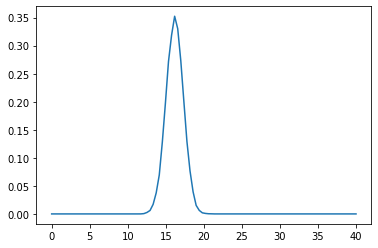

In [5]:
x = np.linspace(0, 40, 100)
plt.plot(x, f([mu, sigma]).pdf(x))

对cdf进行测试

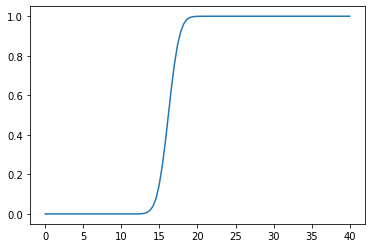

In [6]:
plt.plot(x, f([mu, sigma]).cdf(x))

# 基于最大熵准则的优化反演
基于最大熵准备，以kl散度为优化目标，建立内压p的分布为自变量的优化目标函数。

In [7]:
def obj_me(x0, a=0, b=0):
    mu = x0[0]
    sigma = x0[1]
    # x = np.linspace(0, 40, 200)
    x = np.linspace(0, 50, 100)
    return sum(kl_div(f([20, 1.5]).pdf(x), f([mu, sigma]).pdf(x))) / len(x)


print(f"{obj_me([20, 2])=}")

obj_me([20, 2])=0.0013613344685198946


利用实验结果作为约束条件

In [8]:
cons = [
    {
        "type": "ineq",
        "fun": lambda x, exp_ou, y_ecdf_l: f(x).cdf([exp_ou[i]]) - y_ecdf_l[i],
        "args": (exp_ou, y_ecdf_l),
    }
    for i in range(5)
]

进行优化求解。方法选择很多，为方便操作，本例选用[scipy cobyla方法](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cobyla.html)

In [9]:
x0 = np.array([20, 2])
res = minimize(
    obj_me,
    x0,
    args=(exp_ou, y_ecdf_l),
    method="COBYLA",
    # method="SLSQP",
    # method="trust-constr",
    constraints=cons,
)

res

     fun: 0.0173890683194285
   maxcv: 6.815659148173836e-13
 message: 'Optimization terminated successfully.'
    nfev: 42
  status: 1
 success: True
       x: array([16.70854427,  3.22702768])

将优化结果呈现在cdf图中。

Text(0.5, 1.0, 'finding optimum cdf of Y based on maximum entropy')

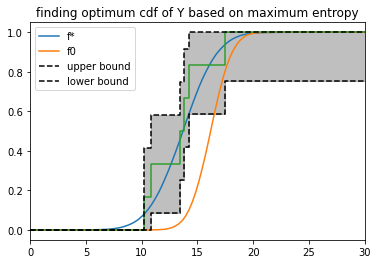

In [10]:
x_test = np.linspace(0, 30, 100)
plt.plot(x_test, f(res.x).cdf(x_test), label="f*")
plt.plot(x_test, f(x0).cdf(x_test), label="f0")
plt.step([0, *exp_ou, 40], [0, *y_ecdf, 1], where="post")
plt.step([0, *exp_ou, 40], [0, *y_ecdf_u, 1], "k--", where="post", label="upper bound")
plt.step([0, *exp_ou, 40], [0, *y_ecdf_l, 1], "k--", where="post", label="lower bound")
plt.fill_between(
    [0, *exp_ou, 40],
    [0, *y_ecdf_u, 1],
    [0, *y_ecdf_l, 1],
    step="post",
    alpha=0.5,
    color="grey",
)
plt.xlim(
    [0, 30],
)
plt.legend()
plt.title("finding optimum cdf of Y based on maximum entropy")

优化前后Y的pdf对比。

Text(0.5, 1.0, 'pdf of Y')

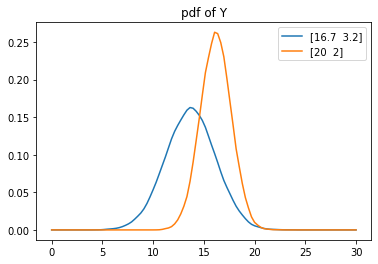

In [11]:
plt.plot(x_test, f(res.x).pdf(x_test), label=f"{res.x.round(1)}")
plt.plot(x_test, f(x0).pdf(x_test), label=f"{x0}")
plt.legend()
plt.title("pdf of Y")

优化前后p的pdf对比。

Text(0.5, 1.0, 'pdf of p')

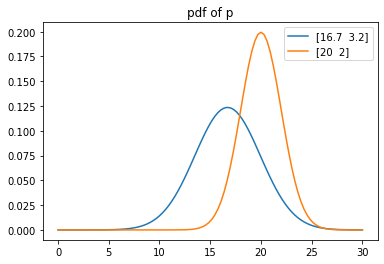

In [12]:
x_test = np.linspace(0, 30, 100)
plt.plot(x_test, stats.norm(*res.x).pdf(x_test), label=f"{res.x.round(1)}")
plt.plot(x_test, stats.norm(*x0).pdf(x_test), label=f"{x0}")
plt.legend()
plt.title("pdf of p")